#Import Libraries

In [201]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 

import time
import re 
import keras
import csv
import random

from tqdm import tqdm_notebook
from tqdm.autonotebook import tqdm

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Load Datasets

In [202]:
from pathlib import Path
from google_drive_downloader import GoogleDriveDownloader as gdd

#bangla_comments.csv
DATA_PATH = 'datasets/bangla_comments.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1Xlmc-4vlYq1hOFgDWhuPCb25vC_L_6i4',
        dest_path=DATA_PATH,
    )

# #diu_bangla_comments.csv
# DATA_PATH = 'datasets/diu_bangla_comments.csv'
# if not Path(DATA_PATH).is_file():
#     gdd.download_file_from_google_drive(
#         file_id='1YQpBo1c6_4cVCnqmaZ1Z47Tsl7sRbOaW',
#         dest_path=DATA_PATH,
#     )

df = pd.read_csv(DATA_PATH)

In [203]:
df.head()

,Unnamed: 0,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,ছবি টা দেখার পর বাড়া টা কেপে ওটলো😭😭😭,1.0,1.0,1.0,0.0,0.0,0.0
1,1,পুতুলের মতো,0.0,0.0,0.0,0.0,0.0,0.0
2,2,nicher ta dekha jacche Apu 😅😅😅😅😅,1.0,1.0,1.0,0.0,0.0,0.0
3,3,ছাগলের দল ফুল ভিডিও দেখ,1.0,0.0,0.0,0.0,0.0,0.0
4,4,পুরাই আগুন 🥰🥰🥰😌,1.0,0.0,0.0,0.0,0.0,0.0


#Data Analysis and Visualization

In [204]:
#Fearture Data
df['comment_text']

0                     ছবি টা দেখার পর বাড়া টা কেপে ওটলো😭😭😭
1                                              পুতুলের মতো
2                         nicher ta dekha jacche Apu 😅😅😅😅😅
3                                  ছাগলের দল ফুল ভিডিও দেখ
4                                          পুরাই আগুন 🥰🥰🥰😌
                               ...                        
12648    পাশে💘থাকলে💘পাশে💘পাবেন।💘লাইক💘দিলে💘লাইক💘পাবেন️💘ফ...
12649                 অওঅঅঅঅঅঅ মা গ কত্ত চিকন😂😂😂😂😂😂😂😂😂😂😂😂😂
12650                                     কালো এটা কি। 🤔🤔🤔
12651         দিঘী কি সানি লিওন এর মতই নাকি কেউ বলেন জানলে
12652                                       তোর হোগায় ডিম।
Name: comment_text, Length: 12653, dtype: object

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12653 entries, 0 to 12652
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     12653 non-null  int64  
 1   comment_text   12653 non-null  object 
 2   toxic          12648 non-null  float64
 3   severe_toxic   12653 non-null  float64
 4   obscene        12648 non-null  float64
 5   threat         12648 non-null  float64
 6   insult         12650 non-null  float64
 7   identity_hate  12652 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 790.9+ KB


In [206]:
df.describe()

,Unnamed: 0,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,12653.000000,12648.000000,12653.000000,12648.000000,12648.000000,12650.000000,12652.000000
mean,6326.000000,0.377451,0.125188,0.132906,0.033365,0.205138,0.057540
std,3652.750813,0.484768,0.330945,0.339487,0.179595,0.403819,0.232881
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3163.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6326.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9489.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12652.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [207]:
for col in df.columns:
    miss = df[col].isnull().sum()
    if miss>0:
        print("{} has {} missing value(s)".format(col,miss))
    else:
        print("{} has NO missing value!".format(col))

Unnamed: 0 has NO missing value!
comment_text has NO missing value!
toxic has 5 missing value(s)
severe_toxic has NO missing value!
obscene has 5 missing value(s)
threat has 5 missing value(s)
insult has 3 missing value(s)
identity_hate has 1 missing value(s)


In [208]:
#Label Data
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = df[labels].values  
print(y[:5])

[[1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


Text(0, 0.5, 'Number of Comments')

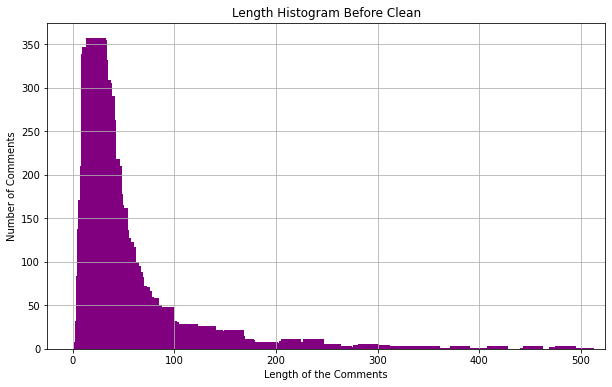

In [209]:
#Count Comments By Length of Comments
lens=df['comment_text'].str.len()
resize = np.arange(0, 500, 1)
lens.hist(color='purple', figsize=(10, 6), bins=resize, width=20)
plt.title('Length Histogram Before Clean')
plt.xlabel('Length of the Comments')
plt.ylabel('Number of Comments')

In [210]:
lens.min()

1

In [211]:
lens.max()

1949

In [212]:
lens.mean()

42.933849679917806

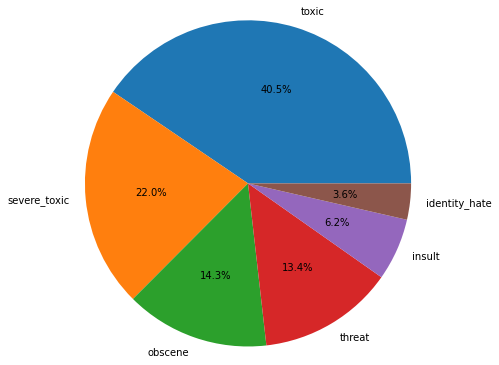

In [213]:
#Count Comments
class_cnt = {}
for label in labels:
    class_cnt[label] = len(df[df[label] == 1])
    
class_cnt = {k: v for k, v in sorted(class_cnt.items(), key = lambda item: item[1], reverse = True)}
values=[*class_cnt.values()]
plt.pie(values, labels=labels, radius=1.5,autopct='%1.1f%%')
plt.show()

In [214]:
#Correlation among classes
flash_data = df[labels]
flash_data.corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.284390,0.276907,0.049642,0.120978,0.121990
severe_toxic,0.284390,1.000000,0.473414,0.077346,0.112574,0.066515
obscene,0.276907,0.473414,1.000000,0.072486,0.016409,0.039236
threat,0.049642,0.077346,0.072486,1.000000,-0.005018,0.018351
insult,0.120978,0.112574,0.016409,-0.005018,1.000000,0.157739
identity_hate,0.121990,0.066515,0.039236,0.018351,0.157739,1.000000


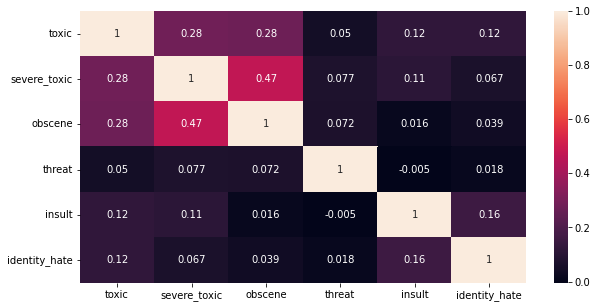

In [215]:
from IPython.core.pylabtools import figsize
plt.figure(figsize(10,5))
dataplot =sns.heatmap(flash_data.corr(), annot=True)
  
# displaying heatmap
plt.show()

#Data Pre-processing

In [216]:
#Drop Null Rows
df1 = df.dropna()

In [217]:
df2 = df1.sample(frac=1)

In [218]:
df2.shape

(12634, 8)

In [219]:
#Replace String

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F970" #love-smile emojy
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    
    text=emoji_pattern.sub(r'', text)

    return text

In [220]:
#Remove Pucntuations
def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct

In [221]:
#Stopword Removal

stopword_list=[]

#Bangla Stopwords
!pip install bnlp_toolkit
from bnlp.corpus import stopwords as bnlp_stop
for word in tqdm_notebook(bnlp_stop):
    stopword_list.append(word)

#English Stopwords
import nltk
from nltk.corpus import stopwords as en_stop
nltk.download('stopwords')
nltk_stopword = set(en_stop.words('english'))
for word in tqdm_notebook(nltk_stopword):
    stopword_list.append(word)


#Banglish_Stopwords search in dataset
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      output=output+" "+word 
  else:
    output=data
  return str(output.strip())


tqdm.pandas()
temp_text = df2['comment_text']
temp_text = temp_text.progress_apply(replace_strings)
temp_text = temp_text.progress_apply(remove_punctuations)


potential_stopwords = []
for line in tqdm_notebook(temp_text): 
    potential_stopwords.append(search_stopwords(line))
print(len(potential_stopwords))


def string_combine(stopword):
  final_d=""
  for item in range(len(df2)-1):
    final_d = final_d +" "+ stopword[item]
  return final_d

total_string_potential=string_combine(potential_stopwords)

def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

total_string_potential_dict=word_count(total_string_potential)

total_string_potential_df = pd.DataFrame(list(total_string_potential_dict.items()),columns = ['Word','Count'])

top500_potential_stopwords=total_string_potential_df.sort_values(by=['Count'],ascending=False).head(500)

all_potential_stopwords =list(top500_potential_stopwords.Word)

#all_potential_stopwords 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/398 [00:00<?, ?it/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/12634 [00:00<?, ?it/s]

  0%|          | 0/12634 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/12634 [00:00<?, ?it/s]

12634


In [222]:
#Banglish Stopwords From Dataset
banglish_stopwords = ['na','ki','er','ta','e','kore','a','ar','o','r','tor','ami','k','kotha','moto',  'ei', 'jonno','comment', 'korte',
                 'nai','akta','ekta','ai','kora','amar','theke','amr','j','ke','tomar','sob','tmi','tmr','hoy','you','hobe','naki',
                 'kichu','por','onek','kono','is','Ami','ase','nah','hoye','gula','sathe','tar','jabe','re','niye','pore','bole',
                 'tumi','onk','plz','din','ha','ache','chilo','te','mone','tui','sobai','shob','jai','koro','toh','kisu','jodi','diye',
                 'thik','ra','abar', 'or','hoi','Tor','keno','jara','je','ato','amra','koren','eta','mon','tai','kaj','Amar','der',
                 'kintu','Ki','apnr','lage','tore','dite','hok','hole','tara', 'kicu','koi','apnar','keu','dekha','korar', 'chai',
                 'hoito','ektu','are',  'oi','R',  'pare', 'tahole','amader','apni','chole','koira','tora','laglo','haste','ja',
                 'korse','den','pola','eto','aro', 'ek','kori','u','ata','thake', 'korbe',  'koto', 'kothay', 'korle']

for word in tqdm_notebook(banglish_stopwords):
    stopword_list.append(word)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/135 [00:00<?, ?it/s]

In [223]:
print(len(stopword_list))

712


In [224]:
banglish_stopword = list(dict.fromkeys(stopword_list))

In [225]:
print(len(banglish_stopword))

705


In [226]:
def stopwordRemoval(text):
  x=str(text)
  l=x.split()
  stm=[elem for elem in l if elem not in bnlp_stop]  
  out=' '.join(stm)  
  return str(out)

In [227]:
#Bangla Stemmer 
!pip install bangla-stemmer

from bangla_stemmer.stemmer.stemmer import BanglaStemmer


def stemming(text):
  output =''
  x=str(text)
  l=x.split()
  for word in l:
    stmr = BanglaStemmer()
    stm = stmr.stem(word) 
    output=output + " " + stm
  return output

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [228]:
#Created My Cleaner
def myCleaner(text):
  text = replace_strings(text)
  text = remove_punctuations(text)
  text = stopwordRemoval(text)
  text = stemming(text)
  return text

In [229]:
#Cleaning Feature Data
tqdm.pandas()
comments = df2['comment_text']
my_cleaned_comments = comments.progress_apply(myCleaner)

  0%|          | 0/12634 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied second rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied second rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..


In [230]:
#Show Result Before and After Cleaning
df3 =df2.copy()
df3['comment_text'] = my_cleaned_comments

In [231]:
df2['comment_text'][2500] #Before

'কালো টা কি আপু জানাবেন plz 🥰'

In [232]:
df3['comment_text'][2500] #After

' কালো টা আপু জানা plz'

In [233]:
df2['comment_text'][700] #Before

'গ্রামের মেয়ে তো অনেক সুন্দর নাচে'

In [234]:
df3['comment_text'][700] #After

' গ্রাম মায় সুন্দর নাচে'

In [235]:
#Final Dataset
df4 = df3.copy()

In [236]:
#Get the Independent Features
X = df4['comment_text']

In [237]:
#Get the Dependent Labels
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = df4[labels].values  

In [238]:
X.shape

(12634,)

In [239]:
y.shape

(12634, 6)

In [240]:
#Initialize Vocabulary size
voc_size = 5000

In [241]:
#Onehot Representation
from keras.preprocessing.text import one_hot
corpus = X.copy()

In [242]:
corpus[90]

' কলিজা লাইক দিয়ে ফলো করো সময় পাশে পাবা ইনশাআল্লাহ'

In [243]:
onehot_repr=[one_hot(words, voc_size)for words in corpus] 
onehot_repr

[[4669, 4622],
 [1081,
  2064,
  206,
  1465,
  4753,
  1823,
  842,
  4217,
  1727,
  2059,
  3162,
  2292,
  1889,
  4694,
  3585,
  1252],
 [472, 4049],
 [70, 4919, 933, 4981, 4692, 1281],
 [1639, 1977],
 [542,
  297,
  3026,
  944,
  4092,
  4026,
  3328,
  471,
  3402,
  118,
  483,
  3114,
  97,
  2533,
  1032,
  168,
  842,
  4960],
 [2216, 3804],
 [4011,
  4085,
  2785,
  413,
  2814,
  3855,
  1617,
  52,
  1605,
  4031,
  2473,
  826,
  3845,
  3097,
  1684,
  4013,
  4454,
  1584,
  1964,
  147,
  2473,
  3287,
  174,
  4452,
  2884,
  404,
  174,
  3638],
 [2847, 3445, 1925, 4615, 3700, 92, 4368],
 [2386,
  2612,
  3462,
  2686,
  2620,
  4829,
  3287,
  2585,
  832,
  3549,
  677,
  1984,
  4931,
  1110,
  3999,
  4857,
  2686,
  832,
  4364],
 [4031, 2694, 3293],
 [1962, 507],
 [39, 1907, 204, 2407, 4601, 4513, 4031],
 [3725,
  2348,
  843,
  4454,
  3146,
  2492,
  339,
  3418,
  1761,
  3513,
  2331,
  1626,
  174,
  378,
  4985,
  4985,
  649,
  3499,
  3918,
  4389,
 

In [244]:
keras.__version__

'2.9.0'

In [245]:
#Embedding Representation
from keras_preprocessing.sequence import pad_sequences
sent_length = 20
embedded_docs = pad_sequences(onehot_repr,
                            padding ='pre',
                            maxlen = sent_length)
print(embedded_docs)

[[   0    0    0 ...    0 4669 4622]
 [   0    0    0 ... 4694 3585 1252]
 [   0    0    0 ...    0  472 4049]
 ...
 [   0    0    0 ...    0  543  143]
 [   0    0    0 ... 1837 2382 2846]
 [   0    0    0 ...  271 4767 1713]]


In [246]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 4669, 4622], dtype=int32)

In [247]:
len(embedded_docs), y.shape

(12634, (12634, 6))

In [248]:
#Convert to Numpy Array
X_final = np.array(embedded_docs)
y_final = np.array(y)

In [249]:
X_final.shape, y_final.shape

((12634, 20), (12634, 6))

In [250]:
#Split Train and Test Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, shuffle = True, random_state=42)

In [251]:
print(len(X_train))
print(len(X_test))

10107
2527


#Part-A: Classification of Bangla Toxic Comments

In [252]:
losses = []
accuracies = []
models = []
approch = []

##Model-01: LSTM - Long Short-term Memory (RNN)

In [253]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout

In [254]:
## Design model
embedding_vector_features = 40
lstm_model=Sequential()
lstm_model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(128))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(6, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 40)            200000    
                                                                 
 dropout_6 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               86528     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 287,302
Trainable params: 287,302
Non-trainable params: 0
_________________________________________________________________
None


In [255]:
#Model Training
history_lstm = lstm_model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 2, batch_size = 32)

Epoch 1/2
316/316 [==============================] - 23s 64ms/step - loss: 0.3975 - accuracy: 0.8069 - val_loss: 0.3491 - val_accuracy: 0.8326
Epoch 2/2
316/316 [==============================] - 22s 69ms/step - loss: 0.3403 - accuracy: 0.7976 - val_loss: 0.3300 - val_accuracy: 0.8362


In [256]:
#Append Data to List
models.append("LSTM")
losses.append(float("{:.2f}".format(history_lstm.history['val_loss'][1])))
accuracies.append(float("{:.2f}".format(history_lstm.history['val_accuracy'][1]*100)))

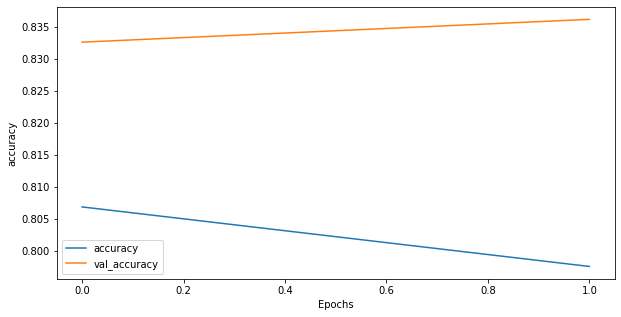

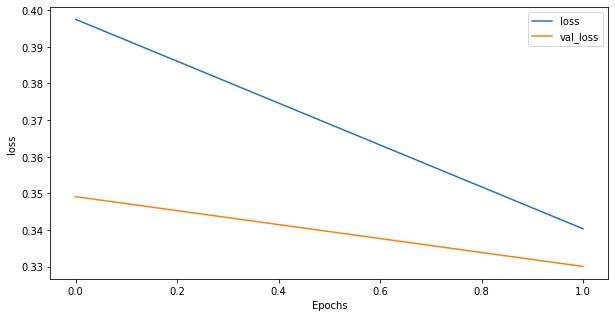

In [257]:
#Plotting Graph
def plot_graphs(history_lstm, string):
  plt.plot(history_lstm.history[string])
  plt.plot(history_lstm.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

##Model-02: LSTM(RNN)-CNN

In [258]:
from keras.models import Sequential
from keras.layers import Dropout, Conv1D, MaxPooling1D, GlobalMaxPool1D
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical

In [259]:
#Model Design
lstm_cnn_model = Sequential()
lstm_cnn_model.add(Embedding(voc_size, embedding_vector_features, input_length = sent_length))
lstm_cnn_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
lstm_cnn_model.add(MaxPooling1D(pool_size=2))
lstm_cnn_model.add(Dropout(.2))
lstm_cnn_model.add(LSTM(128))
lstm_cnn_model.add(Dropout(.2))
lstm_cnn_model.add(Dense(6, activation='sigmoid'))
lstm_cnn_model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(lstm_cnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 40)            200000    
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 32)            3872      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 32)           0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 10, 32)            0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               82432     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                      

In [260]:
#Model Training
history_lstm_cnn = lstm_cnn_model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 2, batch_size = 32)

Epoch 1/2
316/316 [==============================] - 10s 25ms/step - loss: 0.3946 - accuracy: 0.7946 - val_loss: 0.3450 - val_accuracy: 0.8326
Epoch 2/2
316/316 [==============================] - 7s 22ms/step - loss: 0.3368 - accuracy: 0.8181 - val_loss: 0.3357 - val_accuracy: 0.8326


In [261]:
#Append Data to List
models.append("LSTM-CNN")
losses.append(float("{:.2f}".format(history_lstm_cnn.history['val_loss'][1])))
accuracies.append(float("{:.2f}".format(history_lstm_cnn.history['val_accuracy'][1]*100)))

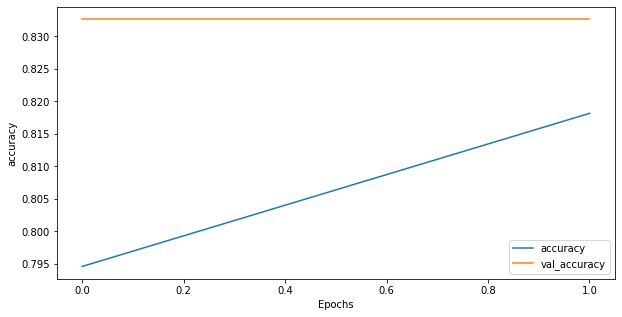

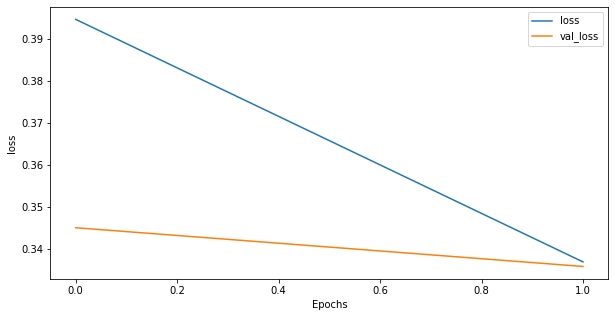

In [262]:
#Plotting Graph
def plot_graphs(history_lstm, string):
  plt.plot(history_lstm_cnn.history[string])
  plt.plot(history_lstm_cnn.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_lstm_cnn, 'accuracy')
plot_graphs(history_lstm_cnn, 'loss')

##Result Analysis and Visualisation of Classification

In [263]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import itertools

In [264]:
#Define Colors
color = itertools.cycle(['b', 'g', 'c', 'm', 'y', '#a99eff'])

In [265]:
#View All List
print(models)
print(losses)
print(accuracies)

['LSTM', 'LSTM-CNN']
[0.33, 0.34]
[83.62, 83.26]


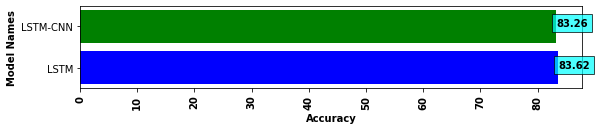

In [266]:
#Accuracy Bar-chart
plt.subplots(figsize =(9,1.5))
plt.ylabel('Model Names',fontweight='bold')
plt.xlabel('Accuracy',fontweight='bold')
plt.xticks(rotation = 90,fontweight='bold')
for i in range(len(models)):   
    plt.barh(models[i], accuracies[i], color = next(color))

for index, value in enumerate(accuracies):
    plt.text(value, index, str(value),weight='bold', bbox = dict(facecolor = 'cyan', alpha =0.7))
    
plt.show()

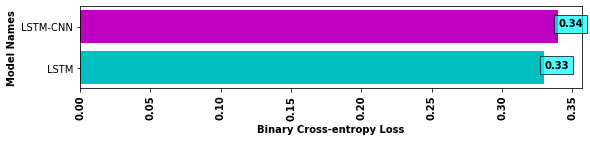

In [267]:
#Loss Bar-chart
plt.subplots(figsize =(9,1.5))
plt.ylabel('Model Names',fontweight='bold')
plt.xlabel('Binary Cross-entropy Loss',fontweight='bold')
plt.xticks(rotation = 90, fontweight='bold')

for i in range(len(models)):
    plt.barh(models[i], losses[i], color = next(color))

for index, value in enumerate(losses):
    plt.text(value, index, str(value),fontweight='bold',bbox = dict(facecolor = 'cyan', alpha =0.7))
plt.show()

In [268]:
#Confution Matrics
from sklearn.metrics import confusion_matrix

y_pred=lstm_model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

79/79 [==============================] - 1s 13ms/step
[[2101    0    0    0    3    0]
 [  74    0    0    0    0    0]
 [  61    0    0    0    1    0]
 [  35    0    0    0    0    0]
 [ 214    0    0    0   12    0]
 [  26    0    0    0    0    0]]


In [269]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']))

               precision    recall  f1-score   support

        toxic       0.84      1.00      0.91      2104
 severe_toxic       0.00      0.00      0.00        74
      obscene       0.00      0.00      0.00        62
       threat       0.00      0.00      0.00        35
       insult       0.75      0.05      0.10       226
identity_hate       0.00      0.00      0.00        26

     accuracy                           0.84      2527
    macro avg       0.26      0.18      0.17      2527
 weighted avg       0.76      0.84      0.77      2527



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [270]:
#Accuracy Score
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)*100

83.61693707954096

#Part-B: Rate Severity of Bangla Toxic Comments

In [271]:
#Actual Severity Score
df_rate = df2[['comment_text','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

df_rate['actual_score'] = 0.0
df_rate['actual_score'] = df_rate['toxic']+ df_rate['severe_toxic']+ df_rate['obscene']+ df_rate['threat']+ df_rate['insult']+ df_rate['identity_hate']

In [272]:
#Prediction Severity Score
pred = lstm_cnn_model.predict(X_final)

df_rate['pred_score'] = 0.0

for i in range(len(pred)):
    df_rate['pred_score'][i]=pred[i][0]+pred[i][1]+pred[i][2]+pred[i][3]+pred[i][4]+pred[i][5]

395/395 [==============================] - 3s 7ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [273]:
#View Dataset with Severity Score
df_rate.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,actual_score,pred_score
4492,hasa ni?,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.681934
4770,"নিজে রোজা রাখবে না, 🙂\nঅথচ এদের জন্য সবার রোযা...",0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.126006
5514,নাইস নাভি,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.225576
3027,Allah onake behes nosib koruk amin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.410027
8394,Abal cuda,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.136722


In [274]:
df_rate['pred_score'].mean()

1.0505710279388278

In [275]:
df_rate['pred_score'].std()

0.7261949685646172

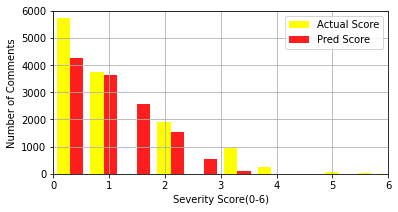

In [276]:
#Severity Distribution
y =df_rate['actual_score'], df_rate['pred_score']

labelsplt = ['Actual Score', 'Pred Score']
color = ["#FFFF00", "#FF1E1E"]
plt.figure(figsize=(6, 3))
plt.hist(y,  label = labelsplt, color = color)
plt.axis([0, 6, 0, 6000])
plt.xlabel('Severity Score(0-6)')
plt.ylabel('Number of Comments')
plt.legend()
plt.grid(True)

In [277]:
# #Severity Accuracy
# from sklearn.metrics import accuracy_score
# acc = accuracy_score(df_rate['actual_score'], df_rate['pred_score'].round())
# print('Severity Accuracy: ', acc )

In [278]:
#Rate Severity of a Comment
def rateSeveity(text):
  clean_text = myCleaner(text)
  onehot_text=[one_hot(clean_text, 1500)for words in clean_text]
  embedded_text = pad_sequences([onehot_text[0]],
                            padding ='pre',
                            maxlen = sent_length)
  final_text = np.array(embedded_text)
  text_pred = lstm_cnn_model.predict(final_text)
  
  print('Classification Result: '+str(text_pred))
  print('Severity Score: '+ str(text_pred.sum()))


In [279]:
text1="দেখে পুড়াই হিজড়ার মতো দেখতে"
rateSeveity(text1)

applied first rules..
applied fourth rules..
1/1 [==============================] - 0s 19ms/step
Classification Result: [[0.25764754 0.05236869 0.06085734 0.01520727 0.15272729 0.03223966]]
Severity Score: 0.5710478


In [280]:
text2="Hi sonaymal muqtadir... Kamon aso ekta gf vaw kore dew na... Khali kiss kormu r kichu na.. Biswas"
rateSeveity(text2)

1/1 [==============================] - 0s 18ms/step
Classification Result: [[0.35342294 0.05583949 0.05473216 0.01609508 0.11662394 0.03449699]]
Severity Score: 0.6312105


In [281]:
#Mean Squared Error(MSE) 
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_rate['actual_score'], df_rate['pred_score'])
print(mse)

1.729655389853975


In [282]:
#Root Mean Squared Error(RMSE)
def root_mean_squared_error(act, pred):

   diff = df_rate['actual_score'] - df_rate['pred_score']
   differences_squared = diff ** 2
   mean_diff = differences_squared.mean()
   rmse_val = np.sqrt(mean_diff)
   return rmse_val

rmse = root_mean_squared_error(df_rate['actual_score'], df_rate['pred_score'])
print(rmse)

1.315163636151021


In [283]:
#Mean Absolute Error (MAE)
def mean_absolute_error(act, pred):
    diff = df_rate['actual_score'] - df_rate['pred_score']
    abs_diff = np.absolute(diff)
    mean_diff = abs_diff.mean()
    return mean_diff

mae = mean_absolute_error(df_rate['actual_score'], df_rate['pred_score'])
print(mae)

1.042976140141197


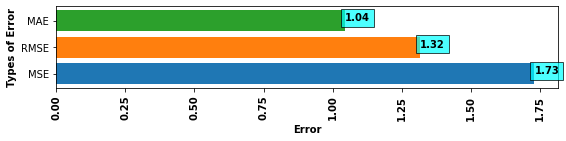

In [284]:
#Errors Bar-Chart
errors = [mse,rmse,mae]
errors_name = ['MSE','RMSE','MAE']

plt.subplots(figsize =(9, 1.5))
plt.ylabel('Types of Error',fontweight='bold')
plt.xlabel('Error',fontweight='bold')
plt.xticks(rotation = 90,fontweight='bold')
for i in range(len(errors_name)):   
    plt.barh(errors_name[i], errors[i])

for index, value in enumerate(errors):
    plt.text(value, index, str("{:.2f}".format(value)),fontweight='bold', bbox = dict(facecolor = 'cyan', alpha =0.7))
    
plt.show()